# Exploring expectiles

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

## Example distribution

We'll want an example multi-modal distribution to play around with. The following code will allow us to work easily with mixtures of multivariate gaussians.

In [2]:
class GMM:
    def __init__(self, coeffs, params):
        self.coeffs = np.array(coeffs)
        self.params = np.array(params)
        self.K = len(coeffs)
        
    def rvs(self, n):
        which_gaussian = np.random.choice(self.K, size=n, p=self.coeffs)
        samples = np.zeros(n)
        for i, (loc, scale) in enumerate(self.params):
            which_samples = (which_gaussian==i)
            count_samples = np.count_nonzero(which_samples)
            samples[which_samples] = stats.norm.rvs(loc, scale, size=count_samples)
        return samples

    def pdf(self, x):
        return sum(c * stats.norm.pdf(x, *ps) for c, ps in zip(self.coeffs, self.params))


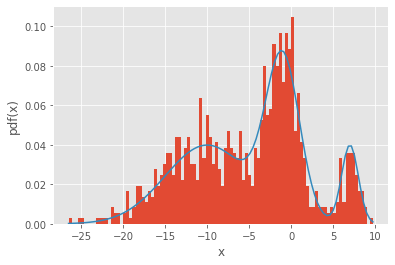

In [3]:
# create a mixture of gaussians
g = GMM(coeffs=[0.1, 0.4, 0.5], params=[[7, 1], [-1, 2], [-10, 5]])

# draw and plot a sample of 1000 points for us to play with
np.random.seed(seed=32)
sample = g.rvs(1000)
plt.hist(sample, density=1, bins=100)
# plot pdf
x = np.linspace(sample.min(), sample.max(), 100)
y = g.pdf(x)
plt.plot(x, y)

plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.show()

$$
\newcommand{\iv }[1]{{[\hspace{-1.5pt}[#1]\hspace{-1.5pt}]}}
\newcommand{\ivt}[3]{{\iv{#1}_{#3}^{#2}}}
$$

## Expectile Regression

Given a distribution $\eta$ with finite second moment, and a $\tau \in [0, 1]$, the $\tau$-expectile of $\eta$, $\epsilon_\tau$ is defined to be the minimising $\epsilon$ of the expectile regression loss $ER(\epsilon; \eta, \tau)$ given by

$$ER(\epsilon;\eta,\tau) = \mathbb{E}_{Z \sim \eta}((\tau\iv{Z \gt \epsilon} + (1-\tau)\iv{Z \leq \epsilon})(Z-\epsilon)^2)$$

ER loss simplifies to

\begin{align*}
    ER(\epsilon;\eta,\tau)
    &=
    \tau\mathbb{E}(\iv{Z \gt \epsilon}(Z-\epsilon)^2) + (1-\tau)\mathbb{E}(\iv{Z \leq \epsilon}(Z-\epsilon)^2)
    \\
    &=
    \tau\int_{z \gt \epsilon}f(z)(z-\epsilon)^2 dz
    \quad
    +
    \quad
    (1-\tau)\int_{z \leq \epsilon}f(z)(z-\epsilon)^2 dz
\end{align*}

where $f(z)$ is the probability density function of the distribution $\eta$.

This shows that the loss is optimised when $\epsilon$ balances a kind of expected squared variation above and below itself, while considering these variations to be unequally important (according to $\tau$ and $1-\tau$, respectively).

#### Notes

ER loss is related to other 'losses' in statistics.

* ER loss is an asymmetric version of the 'square loss', where we consider variation above and below $\epsilon$ equally (as if $\tau=0.5$). The minimiser for the 'square loss' is $\mathbb{E}(Z)$, the *mean*.
* Similarly, we can consider 'quantile regression', where we use the 'quantile loss', an asymmetric version of the absolute value loss. The $\tau=0.5$ quantile is the *median*.

It's in this sense that "expectiles generalise the mean in the same way that quantiles generalise the median".

## Calculating expectiles

The ER loss function is convex and should be easy to numerically optimise. Thus, we can easily calulate $\epsilon_\tau$ of a finite sample's empirical distribution using numerical optimisation:

In [4]:
def ER_loss(eps, tau, sample):
    n = len(sample)
    above_loss = 1/n * np.sum(np.square(sample[sample  > eps] - eps))
    below_loss = 1/n * np.sum(np.square(sample[sample <= eps] - eps))
    return tau * above_loss + (1-tau) * below_loss

def expectile_opt(tau, sample):
    """
    compute sample expectile using optimisation routine
    """
    return opt.minimize(lambda eps: ER_loss(eps, tau, sample), x0=0).x[0]

def expectiles_opt(taus, sample):
    """
    compute sample expectiles for multiple taus using
    optimisation routine
    """
    return [expectile_opt(tau, sample) for tau in taus]




Alternatively, we can express the relationship between $\tau$ and $\epsilon_\tau$ through the derivative of the ER.

\begin{align*}
    -\frac{1}{2}\frac{\partial}{\partial \epsilon} ER(\epsilon;\eta,\tau)
    &=
    \tau\int_{z \gt \epsilon}f(z)(z-\epsilon) dz
    \quad
    +
    \quad
    (1-\tau)\int_{z \leq \epsilon}f(z)(z-\epsilon) dz
    \\
    &=0\qquad\text{(when $\epsilon=\epsilon_\tau$)}
\end{align*}

With some rearrangement, and by introducing

* the cumulative distribution function $F(\epsilon)=\int_{z\leq\epsilon}f(z)dz$,
* the 'partial moment function' $M(\epsilon) = \int_{z\leq\epsilon}z f(z) dz$, and
* the mean $\mu = \int_z z f(z) dz$,

we arrive at the equation:

$$
0
=
 (1-\tau)M(\epsilon_\tau) + \tau(\mu-M(\epsilon_\tau))
-
\epsilon_\tau(
 (1-\tau)F(\epsilon_\tau) + \tau(1-F(\epsilon_\tau))
)
$$

For fixed $\tau$, the RHS expression is a monotonically decreasing function of $\epsilon_\tau$, as shown below for various $\tau$.

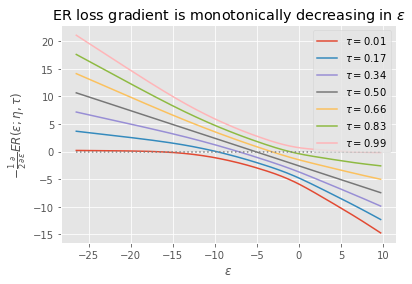

In [5]:
sorted_sample = np.sort(sample)
N = len(sorted_sample)
F = np.cumsum(np.ones_like(sorted_sample)/N)
M = np.cumsum(sorted_sample / N)
mean = M[-1]

for tau in np.linspace(0.01, 0.99, 7):
    prob_balance = ((1 - tau) * F + tau * (1 - F))
    mean_balance = ((1 - tau) * M + tau * (mean - M))
    balance = mean_balance - sorted_sample * prob_balance
    plt.plot(sorted_sample, balance, label=f"$\\tau={tau:.2f}$")

lohi = sorted_sample[0], sorted_sample[-1]
plt.plot(lohi, [0, 0], linestyle=":", color="gray")
plt.ylabel(r"$-\frac{1}{2}\frac{\partial}{\partial \epsilon} ER(\epsilon;\eta,\tau)$")
plt.xlabel(r"$\epsilon$")
plt.title(r"ER loss gradient is monotonically decreasing in $\epsilon$")
plt.legend(loc="upper right")
plt.show()

Moreover, $M$ and $F$ easily computed cumulatively from a finite sample, and can then be queried efficienty at any sample point (noting that their value only changes at sample points).

This suggests a slightly more direct way to compute $\epsilon_\tau$:

1. Sort the sample.
2. Precompute the partial moments $M$ and cumulative probabilities $F$ at each sample point.
3. Scan through the sample points in increasing order evaluating the derivative, until it first becomes passes 0.
4. The sample expectile will be somewhere between the last two sample points queried.

For simplicy, we could just report the sample point with the lowest absolute gradient as the expectile. Or, since for $\epsilon$ between these two points, $M(\epsilon)$ and $F(\epsilon)$ are constant (and equal to $M(\epsilon_{+})$ and F($\epsilon_{+})$ respectively, where $\epsilon_{+}$ is the final positive-gradient sample point), we can directly solve for the exact expectile:

$$
\epsilon_\tau
=
\frac{
    (1-\tau)M(\epsilon_{+}) + \tau(\mu-M(\epsilon_+))
}{
    (1-\tau)F(\epsilon_+) + \tau(1-F(\epsilon_+))
}
$$




In [6]:
def expectiles(taus, sample, from_sample=False):
    expectiles = []
    n = len(sample)
    sorted_sample = np.sort(sample)
    M = np.cumsum(sorted_sample/n)
    F = np.cumsum(np.ones_like(sorted_sample)/n)
    m = M[-1] # mean
    # candidate expectiles (where M[i], F[i] change):
    eps = sorted_sample
    # for each tau:
    # find the eps where this equation is satisfied:
    # 0 = (1-tau)M(eps) + tau(m-M(eps)) - eps((1-tau)F(eps) + tau(1-F(eps)))
    for tau in taus:
        imbalance = (1-tau)*M + tau*(m-M) - eps*((1-tau)*F + tau*(1-F))
        i = np.argmin(np.abs(imbalance))
        if from_sample or imbalance[i] == 0:
            eps_star = eps[i]
        # optionally, refine answer to *exact* expectile in case it's
        # between two sample points:
        elif imbalance[i] > 0:
            # go a little further!
            eps_star = ((1-tau)*M[i] + tau*(m-M[i])) / ((1-tau)*F[i] + tau*(1-F[i]))
        else:
            # go back a little bit!
            eps_star = ((1-tau)*M[i-1] + tau*(m-M[i-1])) / ((1-tau)*F[i-1] + tau*(1-F[i-1]))
        expectiles.append(eps_star)
    return expectiles

The direct method for calculating the sample expectile is slightly faster than the optimisation-based method, presumably because of the savings gained by pre-computing the partial moments and cumulative probabilities, and, further, sharing these across various values of $\tau$.

In [7]:
# compute 99 expectiles between tau=1% and tau=99%
taus = np.linspace(0.01, 0.99, 99)

print("direct method")
%timeit expectiles(taus, sample)

print("\nopt-based method")
%timeit expectiles_opt(taus, sample)

direct method
5.56 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

opt-based method
238 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Further, the approximation of using a sample point as the expectile seems to be fair, at least when we have so many samples as in this case (there is likely to be one close to the true value of the expectile).

total absolute error from approximating optimum using a sample point
1.4219332613728513


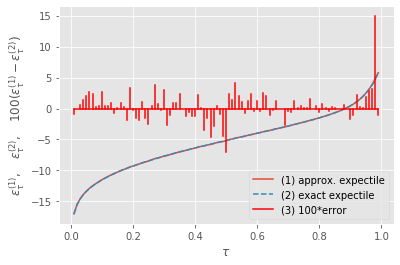

In [8]:
taus = np.linspace(0.01, 0.99, 99)

r1 = np.array(expectiles(taus, sample, from_sample=True ))
r2 = np.array(expectiles(taus, sample, from_sample=False))

print("total absolute error from approximating optimum using a sample point")
print(np.sum(np.abs(r2-r1)))

plt.plot(taus, r1, linestyle="-",  label="(1) approx. expectile")
plt.plot(taus, r2, linestyle="--", label="(2) exact expectile")

for t, d in zip(taus, 100*(r1-r2)):
    plt.plot([t,t], [0,d], color="red")
plt.plot([0.01, 0.99], [0, 0], color="red", label="(3) 100*error")

plt.legend(loc="lower right")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\epsilon_\tau^{(1)},\quad\epsilon_\tau^{(2)},\quad100(\epsilon_\tau^{(1)}-\epsilon_\tau^{(2)})$")
plt.show()

## Plotting expectiles

We can show the expeciles as vertical bars on a histogram, or we can plot the expectiles of a distribution as a function of $\tau \in [0, 1]$.

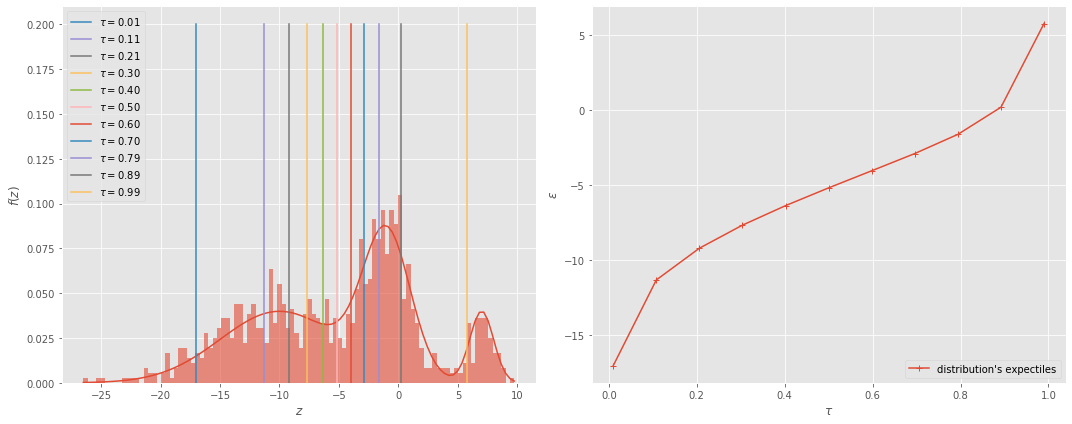

In [9]:
taus = np.linspace(0.01, 0.99, 11)
epss = expectiles(taus, sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(x, y)
ax1.set_prop_cycle(None)
ax1.hist(sample, density=1, alpha=0.6, bins=100)
for tau, eps in zip(taus, epss):
    ax1.plot([eps, eps], [0, 0.2], label=f"$\\tau={tau:.2f}$")

ax1.set_xlabel("$z$")
ax1.set_ylabel("$f(z)$")
ax1.legend(loc="upper left")

ax2.plot(taus, epss, marker='+', label='distribution\'s expectiles')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\epsilon$')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Imputing expectiles

*Imputation* is the process of 'reconstructing' a distribution given a set of expectiles, so that the distribution has those same expectiles.

Formally, given $\tau_i$ and $\epsilon_{\tau_i}$ for $i = 1, \ldots, K$, we seek a distribution $\eta$ such that for all $i \in \{1,\ldots,K\}$, $\epsilon_{\tau_i} = \text{arg min}_\epsilon ER(\epsilon; \eta, \tau_i)$.

Equivalently, we require that $\frac{\partial}{\partial\epsilon} ER(\epsilon; \eta, \tau_i) |_{\epsilon=\epsilon_{\tau_i}} = 0$ (for all $i \in \{1,\ldots,K\}$), or, framed as an optimisation problem over $\eta$, that

$$
\eta
\in
\text{arg min}_\eta
    \sum_{i=1}^K
    \left(
        \frac{\partial}{\partial\epsilon}
        ER(\epsilon; \eta, \tau_i)
        |_{\epsilon=\epsilon_{\tau_i}}
    \right)^2
$$

Note that given any finite set of expectiles, there may be multiple distributions satisfying the constraints given by those expectiles. We will be satisfied with any such distribution.

In particular, if we assume that the distribution is an empirical distribution on $N$ sample points $z_1, \ldots, z_N$ (with $\eta = \sum_{i=1}^{N} \frac{1}{N} \delta_{z_i}$) then the problem is convex and 'particularly tractable', according to the DeepMind paper (their stochastic expetile distributional reinforcement learning algorithm uses $N=K$ and a default scipy optimiser to solve the problem).

In [10]:
def grad_q_half_ER_loss(eps, tau, sample):
    n = len(sample)
    above_grad_loss = 1/n * np.sum(eps - sample[sample  > eps])
    below_grad_loss = 1/n * np.sum(eps - sample[sample <= eps])
    return tau * above_grad_loss + (1-tau) * below_grad_loss
# TODO: I think I could make this more direct using the same kinds of ideas
# as above for the direct computation of the expectiles, and it should
# improve the efficiency of the optimisation process...!

def impute(taus, epss, n, method='min', start='uniform'):
    tes = np.array(list(zip(taus, epss)))

    if start == 'uniform':
        # initialise as uniform distribution between most
        # extreme expectiles
        z0 = np.linspace(epss[0], epss[-1], n)
    elif start == 'bestof1000':
        # this is implemented for 2020 paper to
        # 'significantly improve optimum found'
        # (note: they also repeat this 10 times)
        zs = np.random.uniform(epss[0], epss[-1], (1000, n))
        z0 = zs[np.argmin([sum(ER_loss(eps, t, z) for t, e in zip(taus, epss)) for z in zs])]
    if method=='root':
        k = len(tes)
        if n != k:
            raise Exception("Hey! This method requires n=k (number of expectiles)")
        def q_gradient(sample):
            grad = np.zeros(n)
            grad[:k] = [grad_q_half_ER_loss(e, t, sample) for t, e in tes]
            return grad
        return opt.root(q_gradient, x0=z0).x
    elif method=='min':
        def sum_square_grads(sample):
            return sum(grad_q_half_ER_loss(e, t, sample)**2 for t, e in tes)
        return opt.minimize(sum_square_grads, x0=z0).x

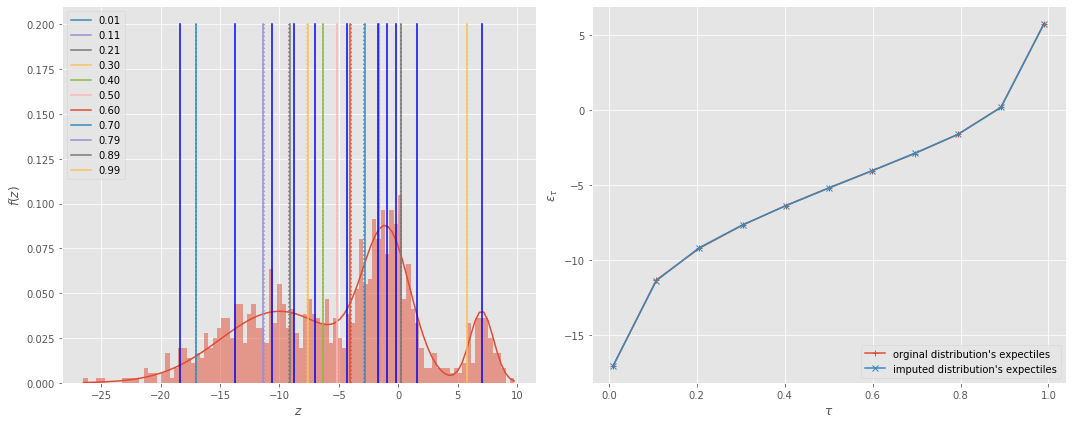

In [11]:
# compute and impute
taus = np.linspace(0.01, 0.99, 11)
epss = expectiles(taus, sample)
imputed_sample = impute(taus, epss, n=len(taus), method='root', start='bestof1000')
imputed_expectiles = expectiles(taus, imputed_sample)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# original sample and expectiles

ax1.set_prop_cycle(None)
ax1.hist(sample, density=1, alpha=0.5, bins=100)
for t, e in zip(taus, epss):
    ax1.plot([e, e], [0, 0.2], linestyle=':')
# new expectiles
ax1.set_prop_cycle(None)
ax1.plot(x, y)
for t, e in zip(taus, imputed_expectiles):
    ax1.plot([e, e], [0, 0.2], label=f"{t:.2f}")
# new sample
for z in imputed_sample:
    ax1.plot([z, z], [0, 0.2], color='blue')
ax1.set_xlabel("$z$")
ax1.set_ylabel("$f(z)$")
ax1.legend(loc="upper left")

# expectiles plot
ax2.plot(taus, epss, marker='+', label='orginal distribution\'s expectiles')
ax2.plot(taus, imputed_expectiles, marker='x', label='imputed distribution\'s expectiles')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\epsilon_\tau$')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [12]:
def compute_and_impute(taus, sample=sample, n=None, method='min', start='bestof1000'):
    if n is None: n = len(taus)

    # compute
    epss = expectiles(taus, sample)
    
    # impute
    imp_samp = impute(taus, epss, n=n, method=method, start=start)
    imp_epss = expectiles(taus, imp_samp)

    # plot results:
    # histogram of original sample:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.hist(sample, density=1, alpha=0.5, bins=100, label="original distribution")
    # imputed sample points:
    for z in imp_samp:
        ax1.plot([z, z], [0, 0.2], color='blue')    
    # gaussian-KDE-smoothed imputed sample distribution:
    imp_dist = stats.gaussian_kde(imp_samp, bw_method=0.2)
    imp_support = np.linspace(min(np.min(sample), np.min(imp_samp)), 
                              max(np.max(sample), np.max(imp_samp)))
    ax1.plot(imp_support, imp_dist.pdf(imp_support), label="imputed distribution (smoothed)")


    ax1.set_xlabel("$z$")
    ax1.set_ylabel("$f(z)$")
    ax1.legend(loc="upper left")

    # expectile comparison plot
    ax2.plot(taus, epss,     marker='+', label='orginal distribution\'s expectiles')
    ax2.plot(taus, imp_epss, marker='x', label='imputed distribution\'s expectiles')
    ax2.set_xlabel(r'$\tau$')
    ax2.set_ylabel(r'$\epsilon_\tau$')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

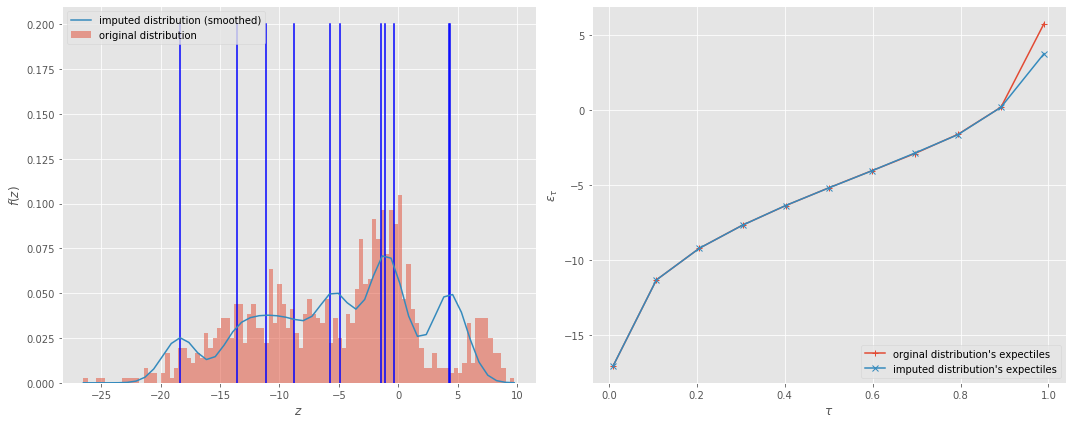

In [13]:
compute_and_impute(taus=np.linspace(0.01, 0.99, 11))

## Playing with the taus

What effect does changing the distribution of expectile biases have on the recovered distribution?

Here I'll use the previously developed sample and imputation methods along with gaussian KDE-smoothing to explore the effect of the tau range on the recovered distribution.

#### What if we nuke the optimistic (or pessimistic) taus?

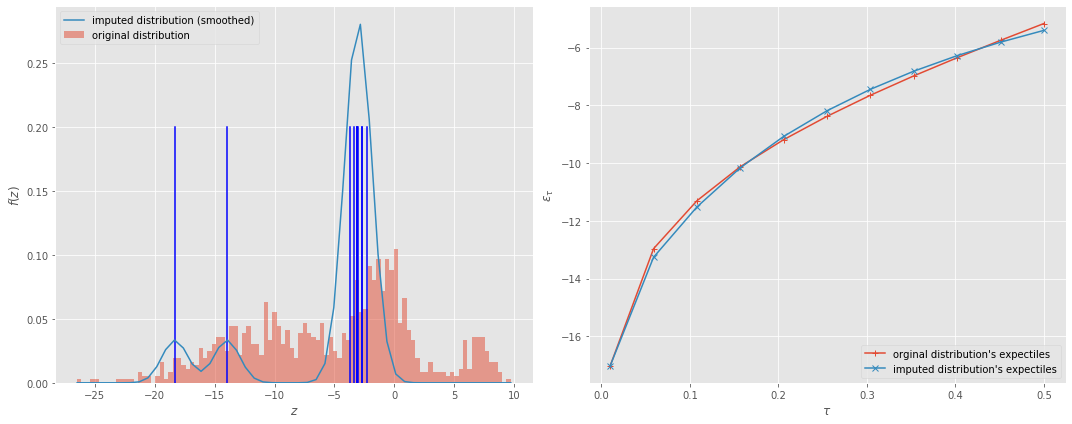

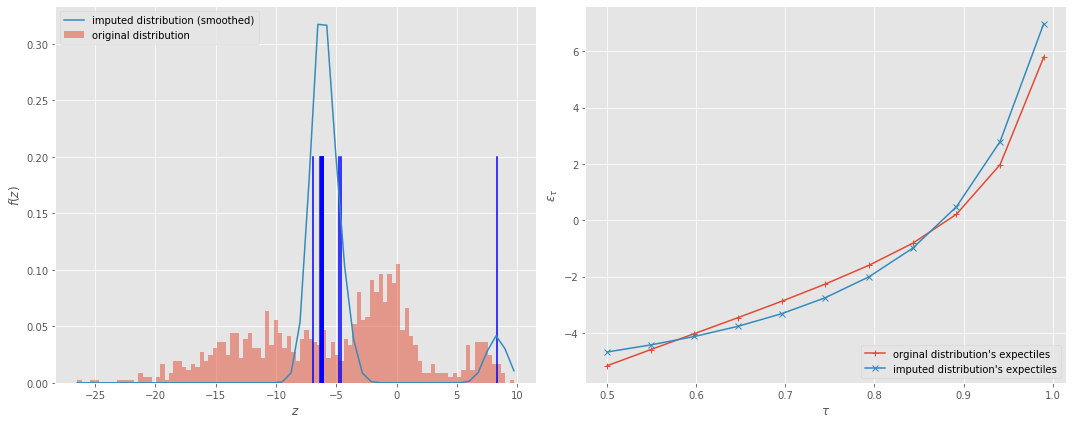

In [14]:
compute_and_impute(taus=np.linspace(0.01, 0.50, 11))
compute_and_impute(taus=np.linspace(0.50, 0.99, 11))

Seems like we struggle to reconstruct a broad distribution, with notable lack of fidelity on the nuked side. What would be the effect on prediction of these distributions?

### What if we restrict the range tightly around the mean?

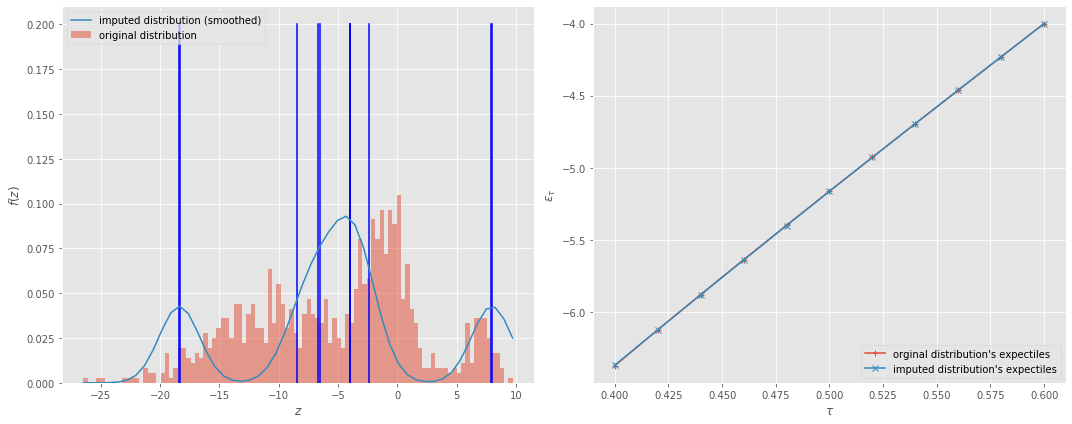

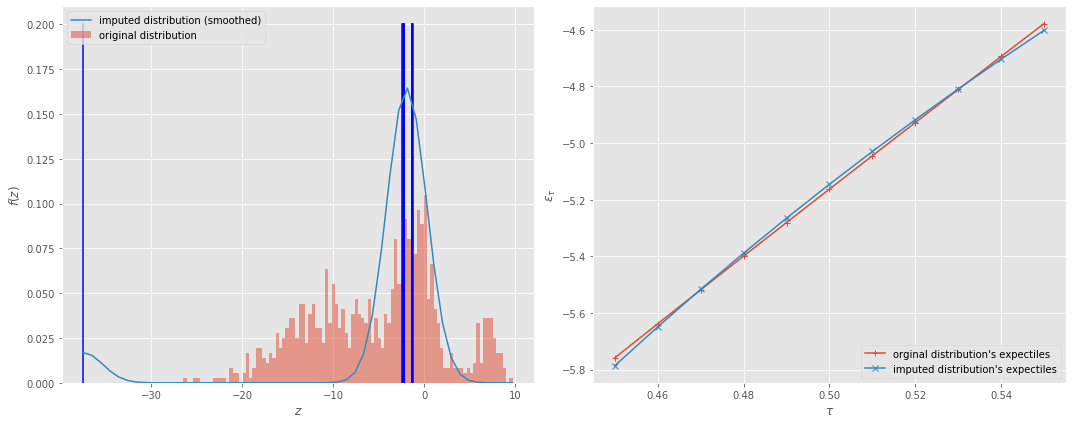

In [15]:
compute_and_impute(taus=np.linspace(0.40, 0.60, 11))
compute_and_impute(taus=np.linspace(0.45, 0.55, 11))

The effect isn't so bad. Well, in the limit, we should recover the mean of the distribution, which was good enough to be state-of-the-art in reinforcement learning until a few years ago!

### What if we use a tight range not including the mean?

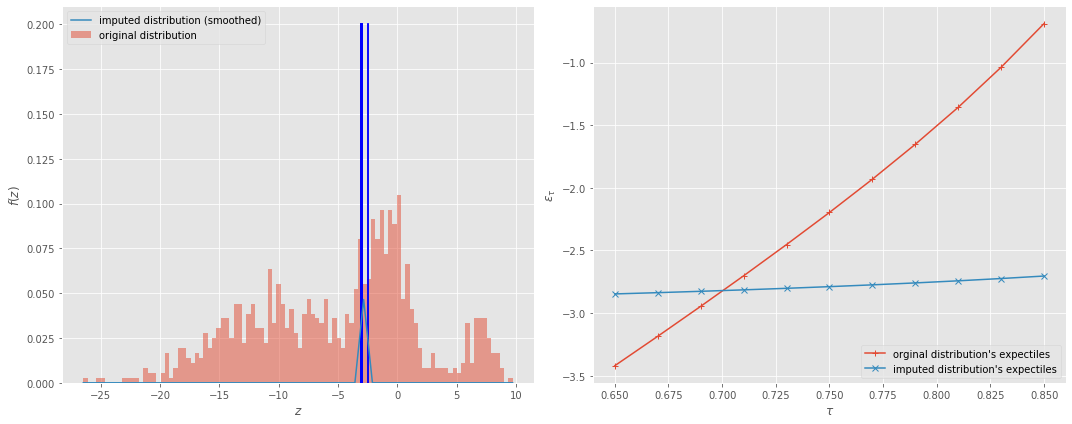

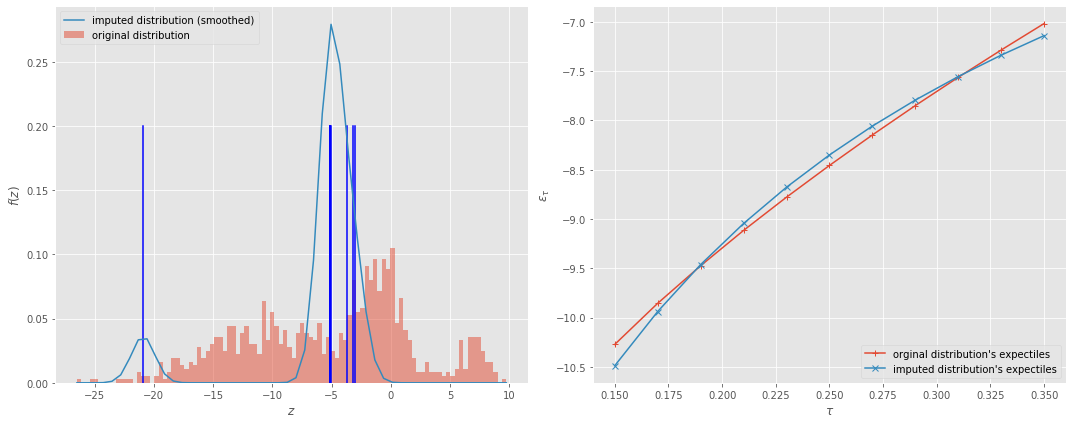

In [16]:
compute_and_impute(taus=np.linspace(0.65, 0.85, 11))
compute_and_impute(taus=np.linspace(0.15, 0.35, 11))

It's like half-way between the other two types.

Notably, it seems that in all cases, we still do a pretty great job of recovering all of the expectiles we kept (how would we go with the ones we didn't keep?).